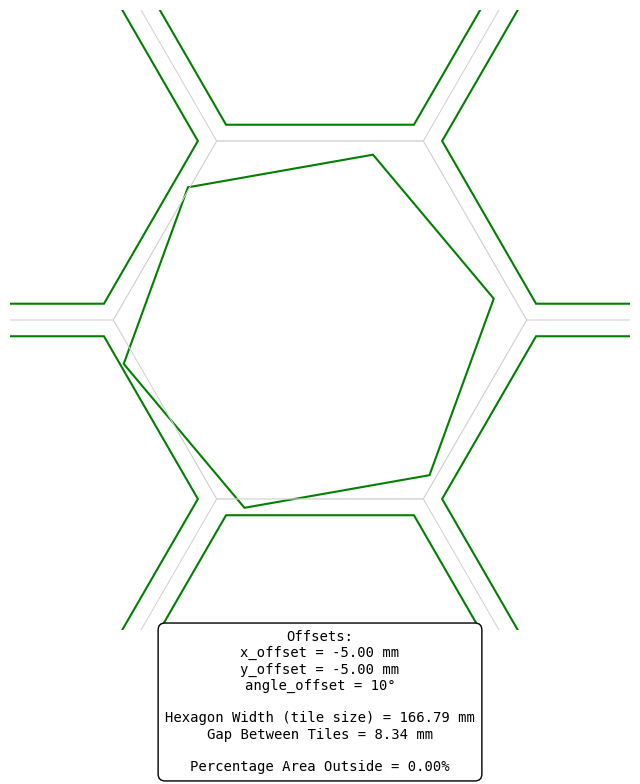

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to draw a single hexagon and return its vertices
def draw_hexagon(ax, center, size, edge_color, face_color, linewidth=1, angle=0):
    x, y = center
    angles = np.linspace(0, 2 * np.pi, 7) + np.radians(angle)  # Apply rotation
    x_hex = x + size * np.cos(angles)
    y_hex = y + size * np.sin(angles)
    ax.fill(x_hex, y_hex, facecolor=face_color, edgecolor=edge_color, linewidth=linewidth)
    return np.column_stack((x_hex, y_hex))  # Return vertices for further processing

# Function to highlight portions of the green hexagon's perimeter that extend beyond the gray hexagon
def draw_red_corners(ax, green_vertices, gray_center, gray_radius):
    for i in range(6):  # Loop through each edge of the green hexagon
        # Get the start and end points of the current edge
        start = green_vertices[i]
        end = green_vertices[(i + 1) % 6]  # Wrap around for the last edge
        
        # Calculate distances of start and end points from the gray hexagon's center
        start_dist = np.linalg.norm(start - gray_center)
        end_dist = np.linalg.norm(end - gray_center)

        # Initialize points for red segments
        outside_points = []

        # Subdivide the edge finely to check for intersections
        direction = end - start
        t_vals = np.linspace(0, 1, 100)
        for t in t_vals:
            point = start + t * direction
            point_dist = np.linalg.norm(point - gray_center)
            if point_dist > gray_radius:
                outside_points.append(point)
            elif outside_points:  # Stop collecting once back inside
                break

        # Highlight the portion of the edge that is outside
        if len(outside_points) >= 2:  # At least two points to form a line
            outside_points = np.array(outside_points)
            ax.plot(
                outside_points[:, 0], outside_points[:, 1],
                color='red', linewidth=2
            )

# Function to calculate the approximate percentage of area outside
def calculate_outside_area(green_vertices, gray_center, gray_radius):
    total_area = 0
    outside_area = 0

    for i in range(6):  # Calculate area of each triangular segment
        triangle = [green_vertices[0], green_vertices[i], green_vertices[i + 1]]
        triangle_area = 0.5 * np.abs(
            triangle[0][0] * (triangle[1][1] - triangle[2][1]) +
            triangle[1][0] * (triangle[2][1] - triangle[0][1]) +
            triangle[2][0] * (triangle[0][1] - triangle[1][1])
        )
        total_area += triangle_area

        # Check if triangle vertices are outside the gray hexagon
        if (np.linalg.norm(triangle[1] - gray_center) > gray_radius or
            np.linalg.norm(triangle[2] - gray_center) > gray_radius):
            outside_area += triangle_area

    percentage_outside = (outside_area / total_area) * 100
    return percentage_outside

# Real-world parameters
real_width = 166.790  # Real-world width of the hexagon in mm

# Current visual parameters
tile_size = 1       # Current "visible" size (radius of green tiles)
current_width = 2 * tile_size  # Current visible width

# Scaling factor
scaling_factor = real_width / current_width

# Updated parameters
tile_size_scaled = tile_size * scaling_factor
gap_scaled = 0.1 * scaling_factor  # Define gap for smooth function integration

# Offset inputs for the central green tile
x_offset = -5.0 #* scaling_factor  # Offset in the x-direction
y_offset = -5.0 #* scaling_factor  # Offset in the y-direction
angle_offset = 10  # Rotation angle in degrees

# Create the plot
fig, ax = plt.subplots(figsize=(8, 10))  # Adjust height for space at the bottom
ax.set_aspect('equal')
ax.set_axis_off()
ax.set_facecolor('white')

# Generate a tiled hexagonal grid
central_green_vertices, central_gray_vertices = None, None
for row in range(-1, 3 + 1):  # Extend to ensure surrounding edges
    for col in range(-1, 3 + 1):
        # Calculate hexagon center positions
        x_base = col * 1.5 * (tile_size_scaled + gap_scaled)
        y_base = row * np.sqrt(3) * (tile_size_scaled + gap_scaled)
        if col % 2 == 1:  # Offset for alternate rows
            y_base += np.sqrt(3) * (tile_size_scaled + gap_scaled) / 2

        # Draw the green hexagon
        if (x_base, y_base) == (0, 0):  # Central hexagon with offsets
            central_green_vertices = draw_hexagon(
                ax,
                (x_base + x_offset, y_base + y_offset),
                tile_size_scaled,
                'green',
                'white',
                linewidth=1.5,
                angle=angle_offset
            )
            central_gray_vertices = draw_hexagon(
                ax,
                (x_base, y_base),
                tile_size_scaled + gap_scaled,
                'lightgray',
                'none',
                linewidth=0.5
            )
        else:  # Neighboring hexagons
            draw_hexagon(ax, (x_base, y_base), tile_size_scaled, 'green', 'white', linewidth=1.5)

        # Draw the outer (gray) hexagon in its original position
        draw_hexagon(ax, (x_base, y_base), tile_size_scaled + gap_scaled, 'lightgray', 'none', linewidth=0.5)

# Highlight red corners for the central hexagon
if central_green_vertices is not None and central_gray_vertices is not None:
    gray_center = np.array([0, 0])
    gray_radius = tile_size_scaled + gap_scaled
    draw_red_corners(ax, central_green_vertices, gray_center, gray_radius)
    percentage_outside = calculate_outside_area(central_green_vertices, gray_center, gray_radius)

# Add the data display at the bottom
plt.text(
    0, -1.5 * (tile_size_scaled + gap_scaled),  # Updated position
    f"Offsets:\n"
    f"x_offset = {x_offset:.2f} mm\n"
    f"y_offset = {y_offset:.2f} mm\n"
    f"angle_offset = {angle_offset}°\n\n"
    f"Hexagon Width (tile size) = {real_width} mm\n"
    f"Gap Between Tiles = {gap_scaled:.2f} mm\n\n"
    f"Percentage Area Outside = {percentage_outside:.2f}%",
    ha='center', va='top', fontsize=10, family='monospace', color='black',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)

# Set a closer zoom for the central hexagon and immediate surroundings
zoom_extent = 1.5 * (tile_size_scaled + gap_scaled)
ax.set_xlim(-zoom_extent, zoom_extent)
ax.set_ylim(-zoom_extent, zoom_extent)

# Show the plot
plt.show()
